**Checking how long the coarse resolution runs take to spinup**

In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

In [2]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:max(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)

In [39]:
%%time
Acontwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.crosseq.aquaplanet.100km.300d/",nfiles=30)
Asmalwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/new.wrf.small.aquaplanet.100km.100d/",nfiles=30)
Asmi2wrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/newinit.wrf.small.aquaplanet.100km.100d/",nfiles=30)
Asmiqwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/newinitq.wrf.small.aquaplanet.100km.100d/",nfiles=30)
Asmizwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/newinitz.wrf.small.aquaplanet.100km.100d/",nfiles=30)


CPU times: user 21.2 s, sys: 6.34 s, total: 27.5 s
Wall time: 22 s


In [4]:
def plotprofiles(sim1,sim2,var,label1,label2,ax=None,level=3,final=True):
    sim1var = sim1[var]
    sim2var = sim2[var]
    renamedict = {}
    if "west_east_stag" in sim1var.dims :
        renamedict = {'west_east_stag':'west_east'}
    if "south_north_stag" in sim1var.dims :
        renamedict = {'south_north_stag':'south_north'}
    if "bottom_top_stag" in sim1var.dims :
        renamedict = {'bottom_top_stag':'bottom_top'}
    sim1var=sim1var.rename(renamedict)
    sim2var=sim2var.rename(renamedict)
    if final : 
        tslice = slice(-200,-1)
    else :
        tslice = slice(200,400)
    if not ax :
        _, ax = plt.subplots(1,1,figsize=(7,4))
    sim1_lat = sim1var.south_north-len(sim1var.south_north)/2
    sim2_lat = sim2var.south_north-len(sim2var.south_north)/2
    if "bottom_top" in sim1var.dims : 
        ax.plot(sim1_lat,sim1var.isel(Time=tslice,bottom_top=level).mean(["Time","west_east"]).persist(),label=label1)
        ax.plot(sim2_lat,sim2var.isel(Time=tslice,bottom_top=level).mean(["Time","west_east"]).persist(),label=label2)
        ax.set_title(sim1[var].description+" at about %i hPa"%(sim1.PB.isel(Time=-1,west_east=0,south_north=len(sim1.south_north)//2,bottom_top=level)/100))
    else :
        ax.plot(sim1_lat,sim1var.isel(Time=tslice).mean(["Time","west_east"]).persist(),label=label1)
        ax.plot(sim2_lat,sim2var.isel(Time=tslice).mean(["Time","west_east"]).persist(),label=label2)
        ax.set_title(sim1[var].description)
    ax.legend()

In [5]:
def plot_diff_levtime(simulation,variable,ax,scale=None):
    initvar = simulation[variable].isel(Time=slice(0,400)).mean(["west_east","south_north"]).persist()
    endvar = simulation[variable].isel(Time=slice(-200,-1)).mean(["Time","west_east","south_north"])
    if scale:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units},cmap=plt.cm.RdBu_r,vmin=-scale,vmax=scale)
    else:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units})
    ax.set_title(simulation[variable].description + " anomaly relative to last 50 days")

In [6]:
def plot_diff_lattime_2d(simulation,variable,ax,scale=None):
    initvar = simulation[variable].isel(Time=slice(0,400)).mean(["west_east"]).persist()
    endvar  = simulation[variable].isel(Time=slice(-200,-1)).mean(["Time","west_east"])
    if scale:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units},cmap=plt.cm.RdBu_r,vmin=-scale,vmax=scale)
    else:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units})
    ax.set_title(simulation[variable].description + " anomaly relative to last 50 days")
    
def plot_diff_lattime_2d_rain(simulation,variable,ax,scale=None):
    initvar = 4*simulation[variable].isel(Time=slice(0,400)).diff('Time').mean(["west_east"]).persist()
    endvar  = 4*simulation[variable].isel(Time=slice(-200,-1)).diff('Time').mean(["Time","west_east"])
    if scale:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units},cmap=plt.cm.RdBu_r,vmin=-scale,vmax=scale)
    else:
        (initvar-endvar).plot(ax=ax, x='Time',cbar_kwargs={"label":simulation[variable].units})
    ax.set_title(simulation[variable].description + " anomaly relative to last 50 days")

In [7]:
def plot_timeseries_diff(simulation,variable,ax,scale=None,with_rolling=False):
    initvar = simulation[variable].isel(Time=slice(0,400))
    endvar  = simulation[variable].isel(Time=slice(-200,-1)).mean('Time').persist()
    ax.plot(initvar.Time,np.sqrt(((initvar-endvar)**2).mean(initvar.dims[1:])))
    ax.set_title(simulation[variable].description + " sqrt(mean sq diff), rel. to last 50 days")
    if with_rolling:
        initvar_rolling = initvar.rolling(Time=40,center=True).mean()
        ax.plot(initvar.Time,np.sqrt(((initvar_rolling-endvar)**2).mean(initvar.dims[1:])),label='10 day rolling mean on the variable')
    
def plot_timeseries_diff_rain(simulation,variable,ax,scale=None):
    initvar = 4*simulation[variable].isel(Time=slice(0,400)).diff('Time').mean('west_east').load()
    initvar_rolling = initvar.rolling(Time=40,center=True).mean()
    endvar  = 4*simulation[variable].isel(Time=slice(-200,-1)).diff('Time').mean(['west_east','Time']).persist() #
    ax.plot(initvar.Time,np.sqrt(((initvar-endvar)**2).mean(initvar.dims[1:])))
    ax.plot(initvar.Time,np.sqrt(((initvar_rolling-endvar)**2).mean(initvar.dims[1:])),label='10 day rolling mean precip')
    ax.set_title(simulation[variable].description + " in the tropics, sqrt(mean sq diff), rel. to last 50 days")
    ax.legend()

# Comparing profiles - 80°x140° vs 60°x100° domains

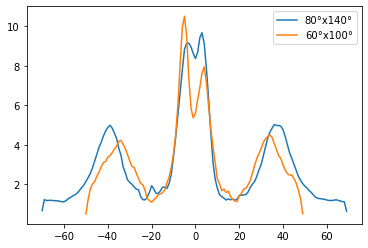

In [9]:
plt.plot(Acontwrf.south_north-70,4*(Acontwrf.RAINC+Acontwrf.RAINNC).isel(Time=slice(-400,-1)).diff('Time').mean(["Time","west_east"]).persist(),label="80°x140°")
plt.plot(Asmalwrf.south_north-50,4*(Asmalwrf.RAINC+Asmalwrf.RAINNC).isel(Time=slice(-400,-1)).diff('Time').mean(["Time","west_east"]).persist(),label="60°x100°")
plt.legend()


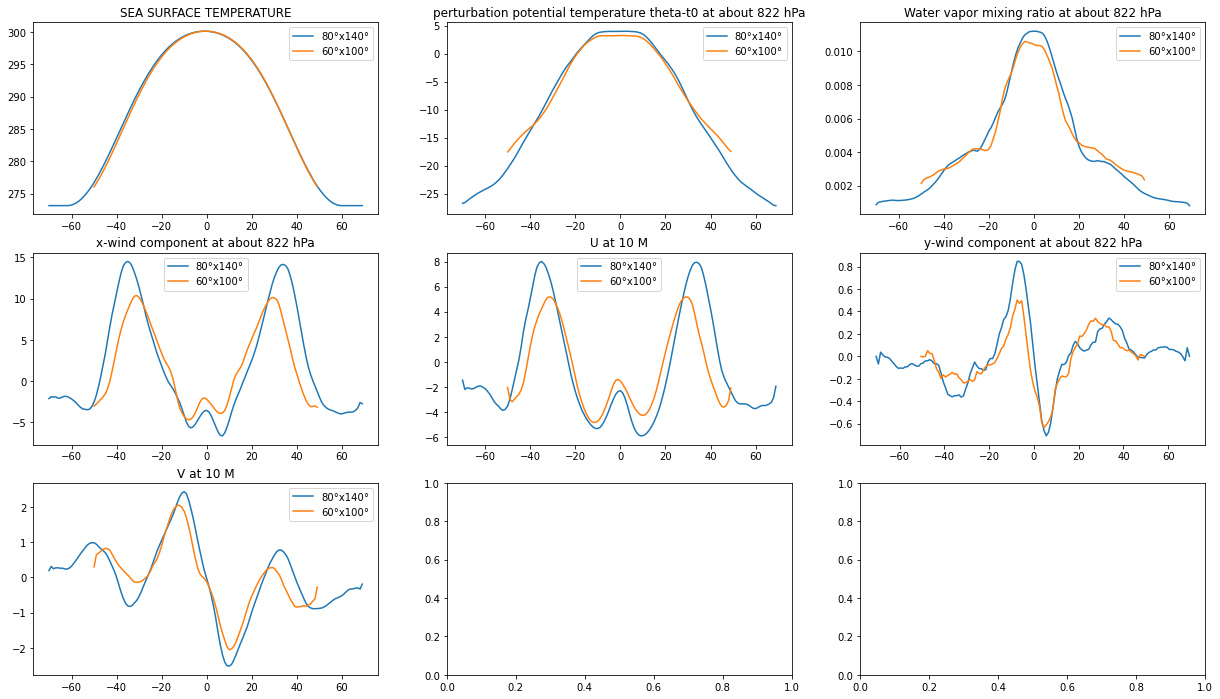

In [10]:
_,ax=plt.subplots(3,3,figsize=(21,12))
ax=ax.reshape(-1)
plotprofiles(Acontwrf,Asmalwrf,'SST'   ,"80°x140°","60°x100°",ax[0])
plotprofiles(Acontwrf,Asmalwrf,'T'     ,"80°x140°","60°x100°",ax[1])
plotprofiles(Acontwrf,Asmalwrf,'QVAPOR',"80°x140°","60°x100°",ax[2])
plotprofiles(Acontwrf,Asmalwrf,'U'     ,"80°x140°","60°x100°",ax[3])
plotprofiles(Acontwrf,Asmalwrf,'U10'   ,"80°x140°","60°x100°",ax[4])
plotprofiles(Acontwrf,Asmalwrf,'V'     ,"80°x140°","60°x100°",ax[5])
plotprofiles(Acontwrf,Asmalwrf,'V10'   ,"80°x140°","60°x100°",ax[6])

# Comparing profiles - 80°x140° - normal sounding vs 5K colder

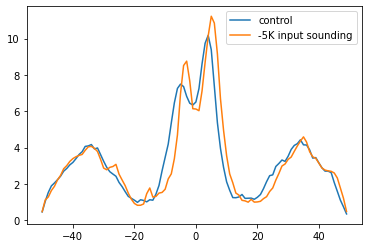

In [12]:
plt.plot(Asmalwrf.south_north-50,4*(Asmalwrf.RAINC+Asmalwrf.RAINNC).isel(Time=slice(200,400)).diff('Time').mean(["Time","west_east"]).persist(),label="control")
plt.plot(Asmi2wrf.south_north-50,4*(Asmi2wrf.RAINC+Asmi2wrf.RAINNC).isel(Time=slice(200,400)).diff('Time').mean(["Time","west_east"]).persist(),label="-5K input sounding")
plt.legend()


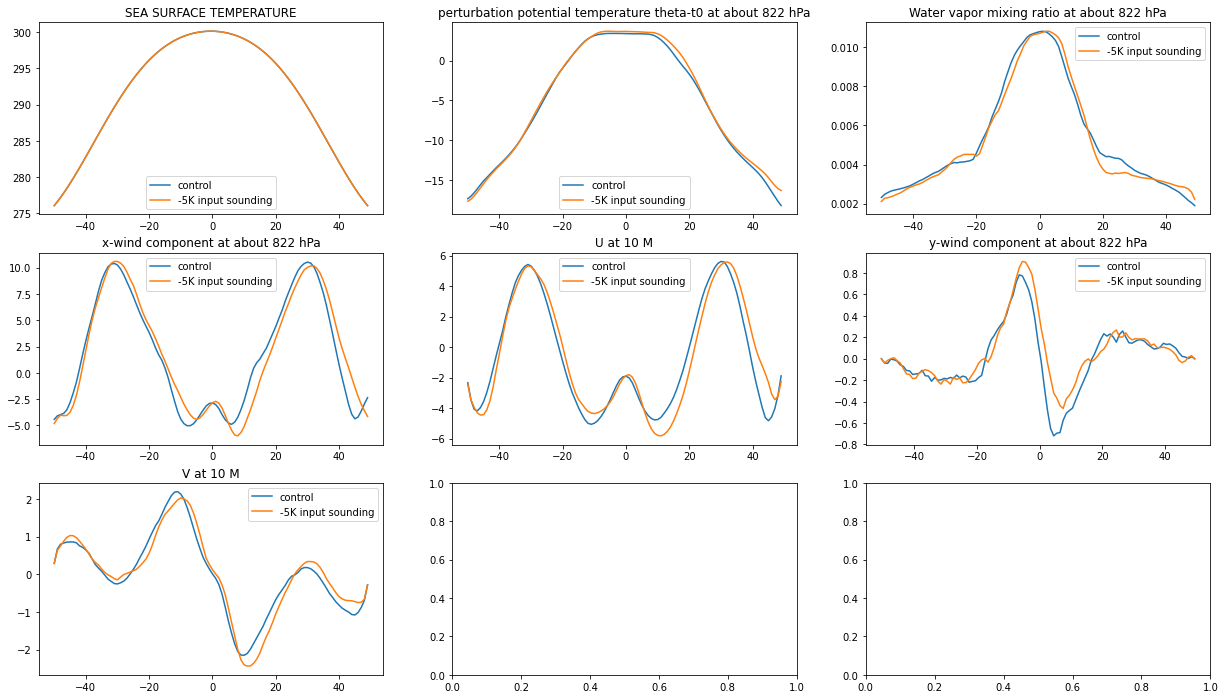

In [13]:
_,ax=plt.subplots(3,3,figsize=(21,12))
ax=ax.reshape(-1)
plotprofiles(Asmalwrf,Asmi2wrf,'SST'   ,"control","-5K input sounding",ax[0],final=False)
plotprofiles(Asmalwrf,Asmi2wrf,'T'     ,"control","-5K input sounding",ax[1],final=False)
plotprofiles(Asmalwrf,Asmi2wrf,'QVAPOR',"control","-5K input sounding",ax[2],final=False)
plotprofiles(Asmalwrf,Asmi2wrf,'U'     ,"control","-5K input sounding",ax[3],final=False)
plotprofiles(Asmalwrf,Asmi2wrf,'U10'   ,"control","-5K input sounding",ax[4],final=False)
plotprofiles(Asmalwrf,Asmi2wrf,'V'     ,"control","-5K input sounding",ax[5],final=False)
plotprofiles(Asmalwrf,Asmi2wrf,'V10'   ,"control","-5K input sounding",ax[6],final=False)

# Comparing profiles - 80°x140° - normal sounding vs 5K warmer & moist

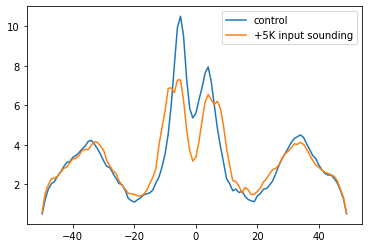

In [63]:
plt.plot(Asmalwrf.south_north-50,4*(Asmalwrf.RAINC+Asmalwrf.RAINNC).isel(Time=slice(-400,-1)).diff('Time').mean(["Time","west_east"]).persist(),label="control")
plt.plot(Asmiqwrf.south_north-50,4*(Asmiqwrf.RAINC+Asmiqwrf.RAINNC).isel(Time=slice(-400,-1)).diff('Time').mean(["Time","west_east"]).persist(),label="+5K input sounding")
plt.legend()


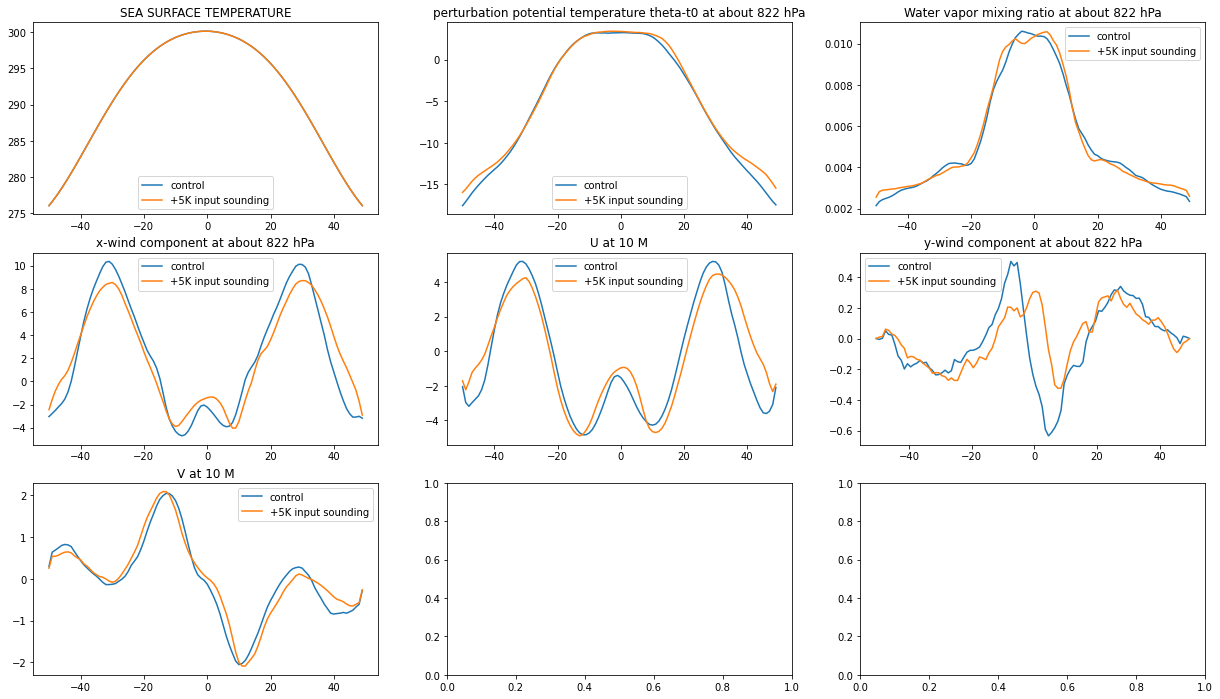

In [42]:
_,ax=plt.subplots(3,3,figsize=(21,12))
ax=ax.reshape(-1)
plotprofiles(Asmalwrf,Asmiqwrf,'SST'   ,"control","+5K input sounding",ax[0],final=True)
plotprofiles(Asmalwrf,Asmiqwrf,'T'     ,"control","+5K input sounding",ax[1],final=True)
plotprofiles(Asmalwrf,Asmiqwrf,'QVAPOR',"control","+5K input sounding",ax[2],final=True)
plotprofiles(Asmalwrf,Asmiqwrf,'U'     ,"control","+5K input sounding",ax[3],final=True)
plotprofiles(Asmalwrf,Asmiqwrf,'U10'   ,"control","+5K input sounding",ax[4],final=True)
plotprofiles(Asmalwrf,Asmiqwrf,'V'     ,"control","+5K input sounding",ax[5],final=True)
plotprofiles(Asmalwrf,Asmiqwrf,'V10'   ,"control","+5K input sounding",ax[6],final=True)

# Comparing profiles - 80°x140° - normal sounding vs sst-dependent

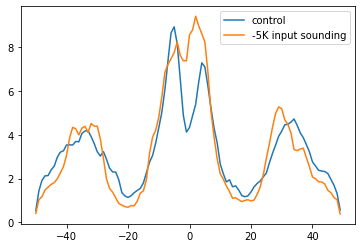

In [40]:
plt.plot(Asmalwrf.south_north-50,4*(Asmalwrf.RAINC+Asmalwrf.RAINNC).isel(Time=slice(-200,-1)).diff('Time').mean(["Time","west_east"]).persist(),label="control")
plt.plot(Asmizwrf.south_north-50,4*(Asmizwrf.RAINC+Asmizwrf.RAINNC).isel(Time=slice(-200,-1)).diff('Time').mean(["Time","west_east"]).persist(),label="-5K input sounding")
plt.legend()


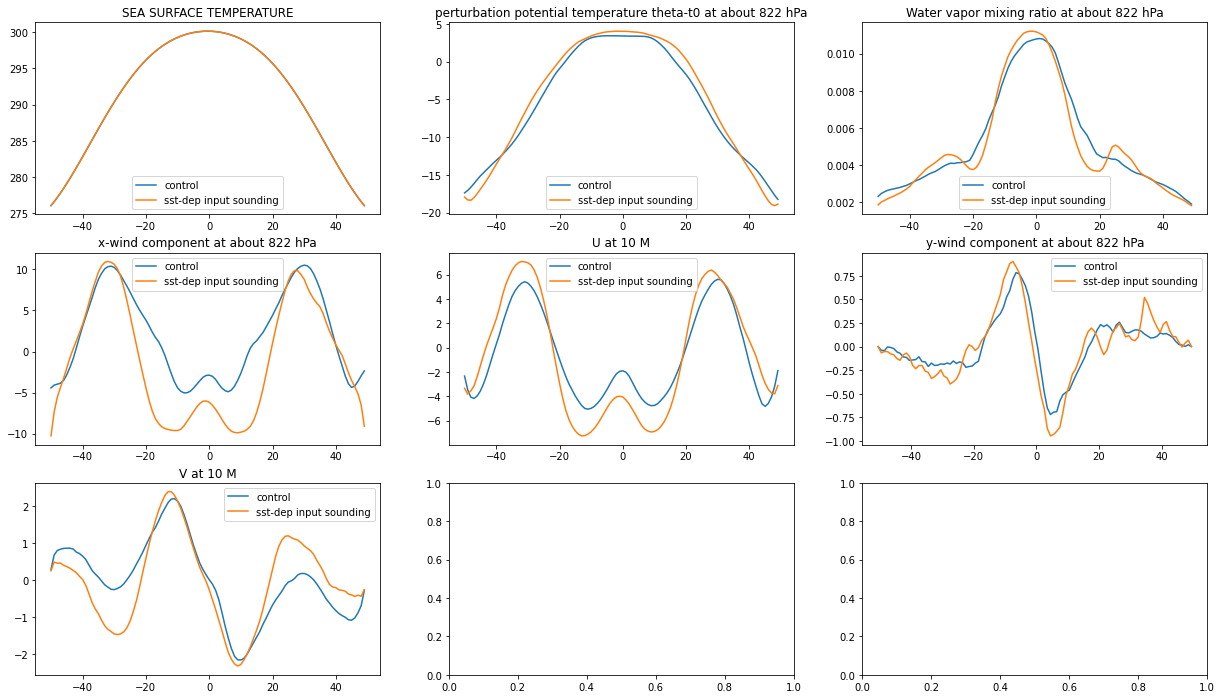

In [45]:
_,ax=plt.subplots(3,3,figsize=(21,12))
ax=ax.reshape(-1)
plotprofiles(Asmalwrf,Asmizwrf,'SST'   ,"control","sst-dep input sounding",ax[0],final=False)
plotprofiles(Asmalwrf,Asmizwrf,'T'     ,"control","sst-dep input sounding",ax[1],final=False)
plotprofiles(Asmalwrf,Asmizwrf,'QVAPOR',"control","sst-dep input sounding",ax[2],final=False)
plotprofiles(Asmalwrf,Asmizwrf,'U'     ,"control","sst-dep input sounding",ax[3],final=False)
plotprofiles(Asmalwrf,Asmizwrf,'U10'   ,"control","sst-dep input sounding",ax[4],final=False)
plotprofiles(Asmalwrf,Asmizwrf,'V'     ,"control","sst-dep input sounding",ax[5],final=False)
plotprofiles(Asmalwrf,Asmizwrf,'V10'   ,"control","sst-dep input sounding",ax[6],final=False)

# Manipulating input sounding

In [52]:
f = open(SCRATCH+'WRF/WRFV4_aq_crosseq/test/em_beta_plane/input_sounding.backup', "r")
alllines=[]
l=[0]
while len(l)>0 :
    l=f.readline().split()
    alllines.append(l)
alllines = alllines[:-1]    

## Shifting -5K

In [21]:
i=0
f = open(SCRATCH+'WRF/WRFV4_aq_crosseq/test/em_beta_plane/input_sounding', "w")
print('{:>10s}{:10.2f}{:>10s}'.format(alllines[0][0],float(alllines[0][1])-5.,alllines[0][2]),file=f)
for i,l in enumerate(alllines[1:]):
    print('{:>10s}{:10.2f}{:>10s}{:>10s}{:>10s}'.format(l[0],float(l[1])+5.,*l[2:]),file=f)
f.close()

In [13]:
print('{:10s}{:10s}{:10s}'.format(*alllines[0]))

1000.000  288.00    0.00      


## Shifting +5K & adding moisture

In [154]:
z = np.array([float(l[0]) for l in alllines[1:]])
theta = np.array([float(l[1]) for l in alllines[1:]])+5.
rcp=0.286

In [146]:
def compute_pressure(z,theta):  
    r=287.
    cp=3.5*r
    g=9.81
    cvpm = -(cp-r)/cp
    pm_input =np.zeros(len(z))
    rho_input=np.zeros(len(z))
    h_input  =z
    th_input =theta
    
    p1000mb=1e5
    p_surf = p1000mb
    th_surf=theta[0]
    rho_surf = 1./((r/p1000mb)*th_surf*((p_surf/p1000mb)**cvpm))
    rho_input[0] = rho_surf
    pm_input[0] = p_surf
    
    for k in range(1,len(z)):
        rho_input[k] = rho_input[k-1]
        dz = h_input[k]-h_input[k-1]
        for _ in range(10):
            pm_input[k] = pm_input[k-1] - 0.5*dz*(rho_input[k]+rho_input[k-1])*g
            rho_input[k] = 1./((r/p1000mb)*th_input[k]*((pm_input[k]/p1000mb)**cvpm))
    return pm_input

In [155]:
p=compute_pressure(z,theta)

In [158]:
q_gkg = 0.8*1000*qsat(theta*(p/1e5)**0.286,p/100)

In [161]:
i=0
f = open(SCRATCH+'WRF/WRFV4_aq_crosseq/test/em_beta_plane/input_sounding', "w")
print('{:>10s}{:10.2f}{:10.2f}'.format(alllines[0][0],float(alllines[0][1])+5.,q_gkg[0]),file=f)
for i,l in enumerate(alllines[1:]):
    print('{:>10s}{:10.2f}{:10.2f}{:>10s}{:>10s}'.format(l[0],theta[i],q_gkg[i],*l[3:]),file=f)
f.close()

# Spinup

## Hovmoellers

Text(0.5, 0.98, 'anomalies relative to the last 50 days; control simulation')

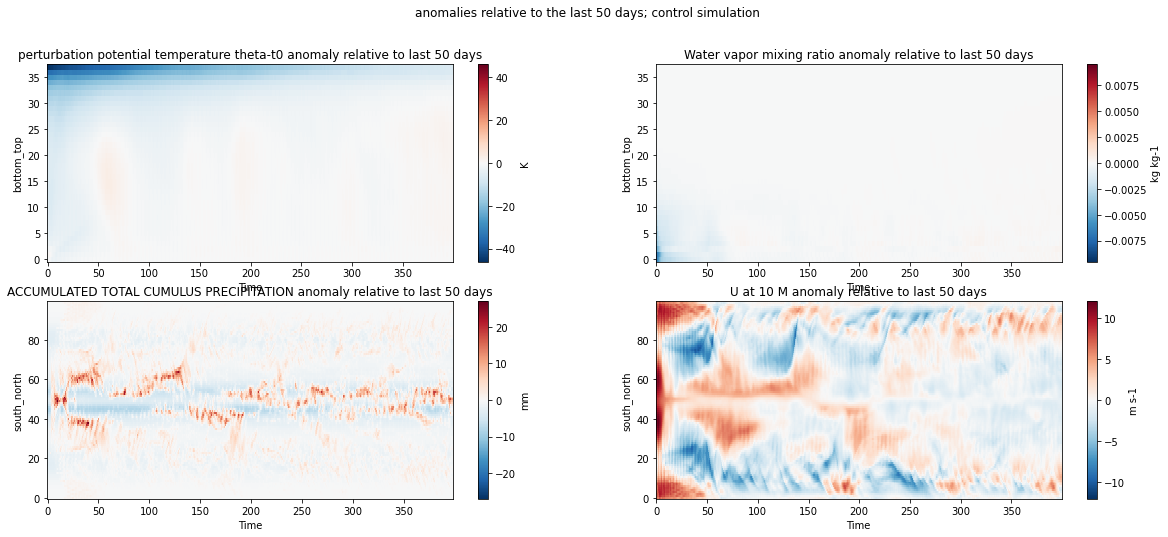

In [50]:
fig, ax = plt.subplots(2,2,figsize=(20,8))
ax=ax.reshape(-1)
plot_diff_levtime(Asmalwrf,"T",ax[0])
plot_diff_levtime(Asmalwrf,"QVAPOR",ax[1])
plot_diff_lattime_2d_rain(Asmalwrf,"RAINC",ax[2])
plot_diff_lattime_2d(Asmalwrf,"U10",ax[3])
fig.suptitle("anomalies relative to the last 50 days; control simulation",fontsize=15)

Text(0.5, 0.98, 'anomalies relative to the last 50 days; with a moist and 5K warmer sounding')

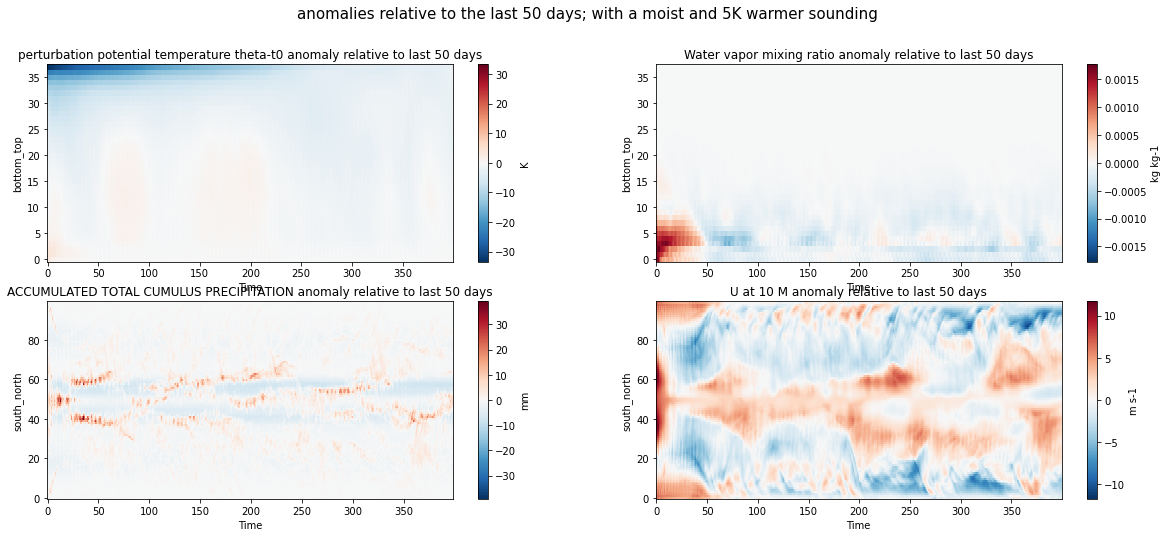

In [51]:
fig, ax = plt.subplots(2,2,figsize=(20,8))
ax=ax.reshape(-1)
plot_diff_levtime(Asmiqwrf,"T",ax[0])
plot_diff_levtime(Asmiqwrf,"QVAPOR",ax[1])
plot_diff_lattime_2d_rain(Asmiqwrf,"RAINC",ax[2])
plot_diff_lattime_2d(Asmiqwrf,"U10",ax[3])
fig.suptitle("anomalies relative to the last 50 days; with a moist and 5K warmer sounding",fontsize=15)

## $\|X - X_{\text{last 50 days}}\|_2$

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0.98, 'anomalies relative to the last 50 days; control')

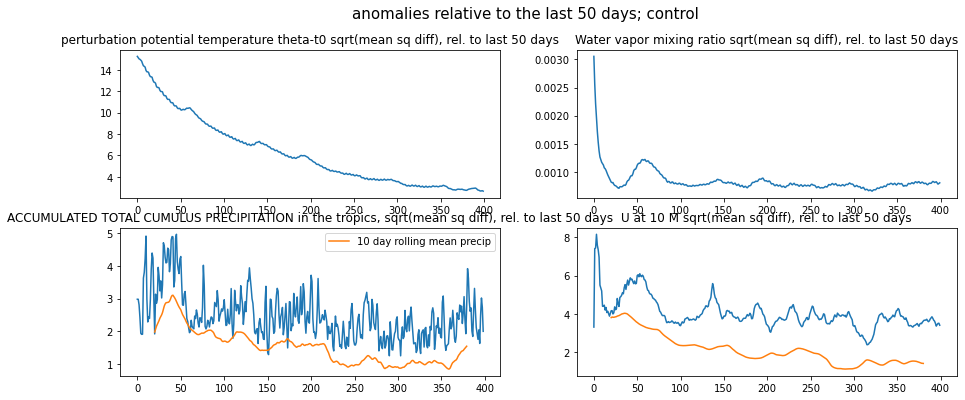

In [59]:

fig, ax = plt.subplots(2,2,figsize=(15,6))
ax=ax.reshape(-1)
plot_timeseries_diff(Asmalwrf,"T",ax[0])
plot_timeseries_diff(Asmalwrf,"QVAPOR",ax[1])
plot_timeseries_diff_rain(Asmalwrf,"RAINC",ax[2])
plot_timeseries_diff(Asmalwrf,"U10",ax[3],with_rolling=True)
fig.suptitle("anomalies relative to the last 50 days; control",fontsize=15)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0.98, 'anomalies relative to the last 50 days; with a moist and 5K warmer sounding')

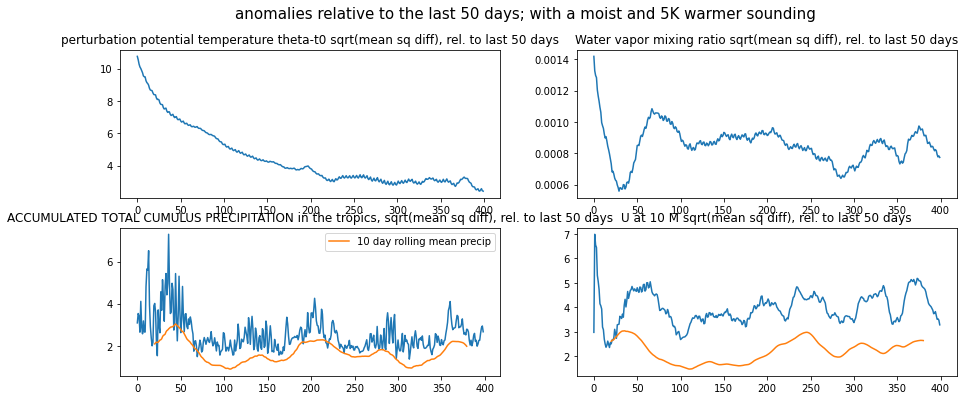

In [58]:

fig, ax = plt.subplots(2,2,figsize=(15,6))
ax=ax.reshape(-1)
plot_timeseries_diff(Asmiqwrf,"T",ax[0])
plot_timeseries_diff(Asmiqwrf,"QVAPOR",ax[1])
plot_timeseries_diff_rain(Asmiqwrf,"RAINC",ax[2])
plot_timeseries_diff(Asmiqwrf,"U10",ax[3],with_rolling=True)
fig.suptitle("anomalies relative to the last 50 days; with a moist and 5K warmer sounding",fontsize=15)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0.98, 'anomalies relative to the last 50 days; with an sst-dependent sounding')

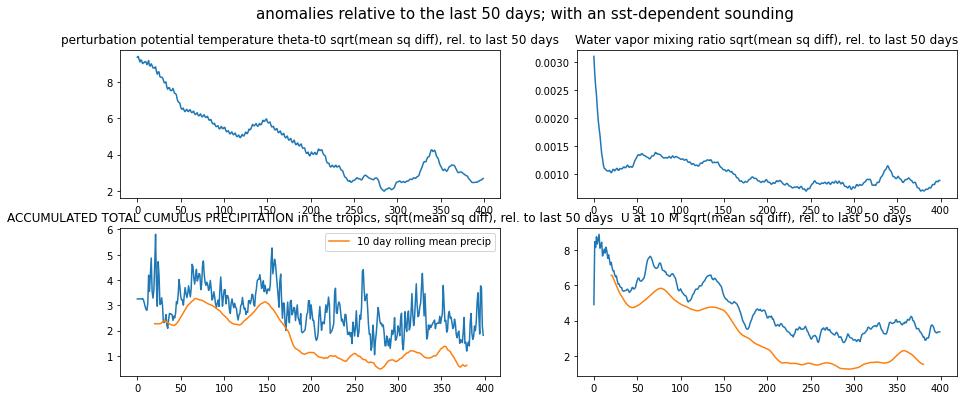

In [57]:

fig, ax = plt.subplots(2,2,figsize=(15,6))
ax=ax.reshape(-1)
plot_timeseries_diff(Asmizwrf,"T",ax[0])
plot_timeseries_diff(Asmizwrf,"QVAPOR",ax[1])
plot_timeseries_diff_rain(Asmizwrf,"RAINC",ax[2])
plot_timeseries_diff(Asmizwrf,"U10",ax[3],with_rolling=True)
fig.suptitle("anomalies relative to the last 50 days; with an sst-dependent sounding",fontsize=15)

## $\|X - Ctl_{\text{last 50 days}}\|_2$

In [37]:
def plot_timeseries_diff2(simulation1,simulation2,variable,ax,scale=None,with_rolling=False):
    initvar = simulation1[variable].isel(Time=slice(0,400))
    initvar2 = simulation2[variable].isel(Time=slice(0,400))
    endvar  = simulation1[variable].isel(Time=slice(-200,-1)).mean('Time').persist()
    ax.plot(initvar.Time,np.sqrt(((initvar-endvar)**2).mean(initvar.dims[1:])),label='control')
    ax.plot(initvar2.Time,np.sqrt(((initvar2-endvar)**2).mean(initvar.dims[1:])),label='compared')
    ax.set_title(simulation1[variable].description + " sqrt(mean sq diff), rel. to last 50 days")
    ax.legend()
    
def plot_timeseries_diff_rain2(simulation1,simulation2,variable,ax,scale=None):
    initvar = 4*simulation1[variable].isel(Time=slice(0,400)).diff('Time').mean('west_east').load()
    initvar_rolling = initvar.rolling(Time=40,center=True).mean()
    endvar  = 4*simulation1[variable].isel(Time=slice(-200,-1)).diff('Time').mean(['west_east','Time']).persist() #
    
    initvar2 = 4*simulation2[variable].isel(Time=slice(0,400)).diff('Time').mean('west_east').load()
    initvar2_rolling = initvar2.rolling(Time=40,center=True).mean()
    
    ax.plot(initvar.Time,np.sqrt(((initvar_rolling-endvar)**2).mean(initvar.dims[1:])),label='10 day rolling mean precip, control')
    ax.plot(initvar2.Time,np.sqrt(((initvar2_rolling-endvar)**2).mean(initvar2.dims[1:])),label='10 day rolling mean precip, compared')
    ax.set_title(simulation1[variable].description + " sqrt(mean sq diff), rel. to last 50 days")
    ax.legend()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0.98, 'anomalies relative to the last 50 days of the control; control & 5K warmer sounding')

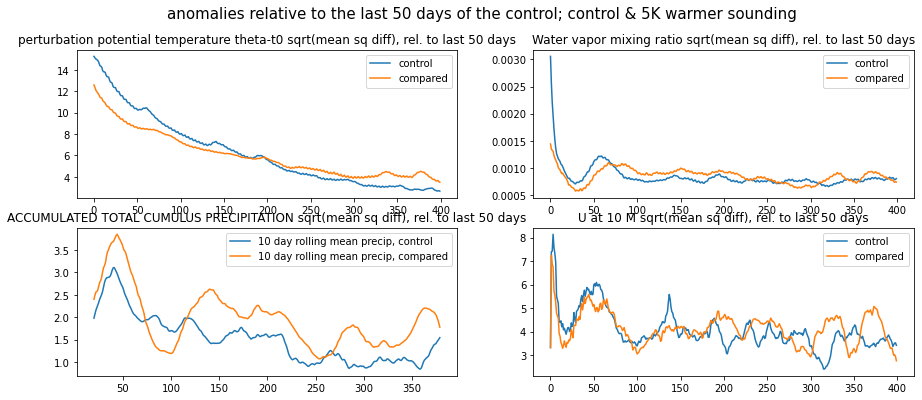

In [56]:

fig, ax = plt.subplots(2,2,figsize=(15,6))
ax=ax.reshape(-1)
plot_timeseries_diff2(Asmalwrf,Asmiqwrf,"T",ax[0])
plot_timeseries_diff2(Asmalwrf,Asmiqwrf,"QVAPOR",ax[1])
plot_timeseries_diff_rain2(Asmalwrf,Asmiqwrf,"RAINC",ax[2])
plot_timeseries_diff2(Asmalwrf,Asmiqwrf,"U10",ax[3])
fig.suptitle("anomalies relative to the last 50 days of the control; control & 5K warmer sounding",fontsize=15)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0.98, 'anomalies relative to the last 50 days of the control; control & sst-dependent sounding')

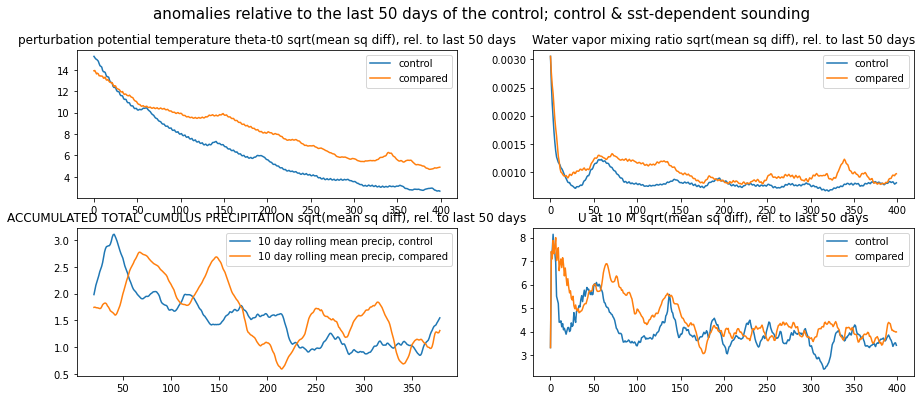

In [60]:

fig, ax = plt.subplots(2,2,figsize=(15,6))
ax=ax.reshape(-1)
plot_timeseries_diff2(Asmalwrf,Asmizwrf,"T",ax[0])
plot_timeseries_diff2(Asmalwrf,Asmizwrf,"QVAPOR",ax[1])
plot_timeseries_diff_rain2(Asmalwrf,Asmizwrf,"RAINC",ax[2])
plot_timeseries_diff2(Asmalwrf,Asmizwrf,"U10",ax[3])
fig.suptitle("anomalies relative to the last 50 days of the control; control & sst-dependent sounding",fontsize=15)

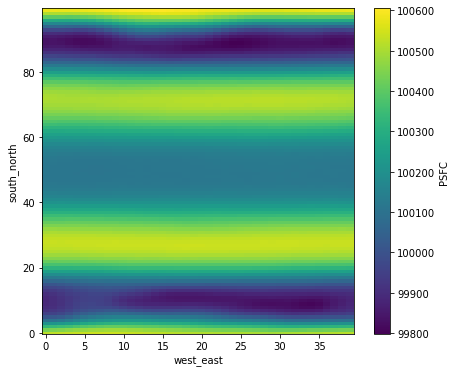

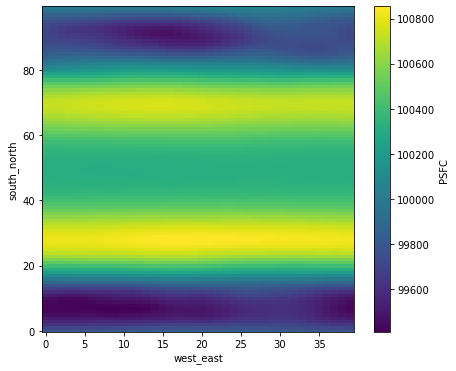

In [49]:
def plot_2dvar(var):
    fig, ax = plt.subplots(1,1,figsize=(7,6))
    var.plot(ax=ax)
    
plot_2dvar(Asmalwrf.PSFC.isel(Time=slice(200,400)).mean('Time'))
plot_2dvar(Asmizwrf.PSFC.isel(Time=slice(200,400)).mean('Time'))